In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [38]:
el_prices = pd.read_excel(r'C:\TIO4317_spring25_project\TIO4317_spring25_project\data\Processed\ice_electric-ave_price-2015-2025.xlsx')
el_prices.set_index('Trade date', inplace=True)

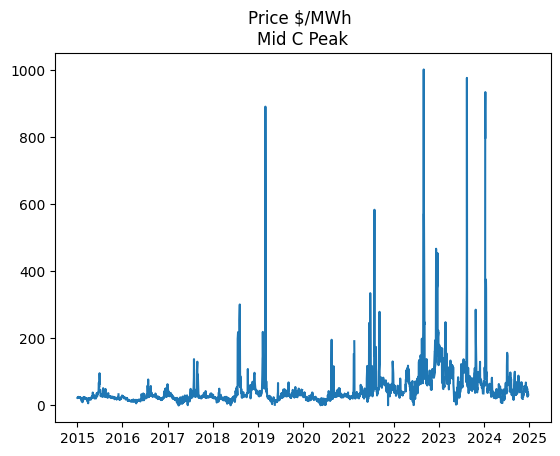

In [39]:
#Velger en, Price Mid C, siden den hadde punkter over hele perioden. 
#1 Exploratory analysis 

plt.figure()
plt.plot(el_prices["Price $/MWh \nMid C Peak"])
plt.title("Price $/MWh \nMid C Peak")
plt.show()

#Mye spikes; antagelig vinter demand. Mer volatilt etter 2021 

In [10]:
#2 Stationarity
from statsmodels.tsa.stattools import adfuller


In [ ]:
#Noen datoer har flere punkter som blir et problem når man skal lage en serie med frequency
#Tok bort duplicates i preprocessing-koden.
duplicates = el_prices.index[el_prices.index.duplicated()]
print(duplicates)

DatetimeIndex([], dtype='datetime64[ns]', name='Trade date', freq=None)


In [44]:
#Define the frequency 
el_price_mid_C = el_prices["Price $/MWh \nMid C Peak"].asfreq('B')


In [43]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if result[1] < 0.05:
        print("Conclusion: The series is likely stationary.")
    else:
        print("Conclusion: The series is likely non-stationary.")

In [46]:
adf_test(el_price_mid_C)

ADF Statistic: -7.5050
p-value: 0.0000
Critical Values:
   1%: -3.4330
   5%: -2.8627
   10%: -2.5674
Conclusion: The series is likely stationary.


In [ ]:
#Overraskende sier den at den er stationary!

#Lager en ARIMA modell

In [50]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

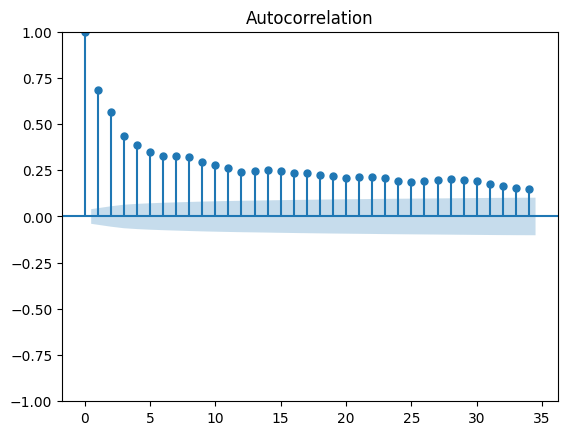

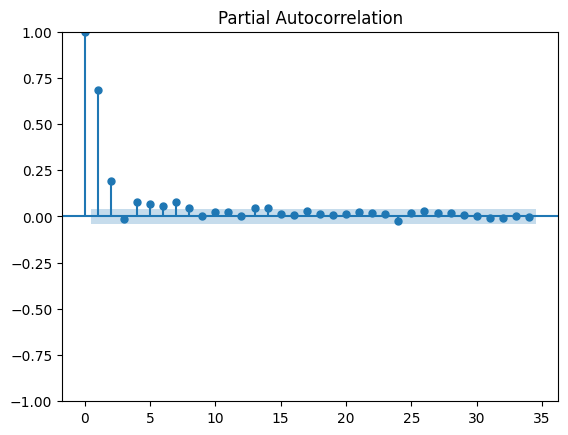

In [52]:
plot_acf(el_price_mid_C.dropna())
plot_pacf(el_price_mid_C.dropna())
plt.show()

#ACF og PACF plots can guide parameter selection. 

p → Autoregressive (AR) term (from PACF plot)

d → Number of differences needed to achieve stationarity

q → Moving average (MA) term (from ACF plot) 

Choose for now: p=3, d=0, q=3
Can also use information criteria: AIC or BIC



In [59]:
p = 3
d = 0 
q = 3

model = ARIMA(el_price_mid_C, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

#Det er noe error her...i forhold til non-stationarity. 

c:\Users\endre\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\endre\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                  SARIMAX Results                                  
Dep. Variable:     Price $/MWh 
Mid C Peak   No. Observations:                 2603
Model:                      ARIMA(3, 0, 3)   Log Likelihood              -12783.152
Date:                     Fri, 21 Mar 2025   AIC                          25582.304
Time:                             16:08:29   BIC                          25629.219
Sample:                         01-02-2015   HQIC                         25599.302
                              - 12-24-2024                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.4001      9.573      4.951      0.000      28.637      66.163
ar.L1          0.2291      0.096      2.396      0.017       0.042       0.416
ar.L2       

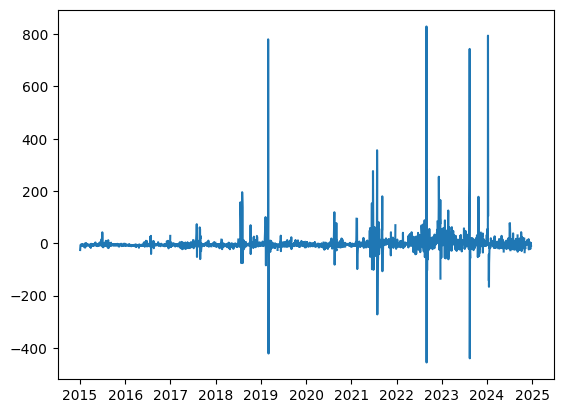

In [ ]:
plt.plot(model_fit.resid)
plt.title("Residuals from ARIMA(3,0,3)")